# 1. 이해하기

## 1.1 DataStore 생성

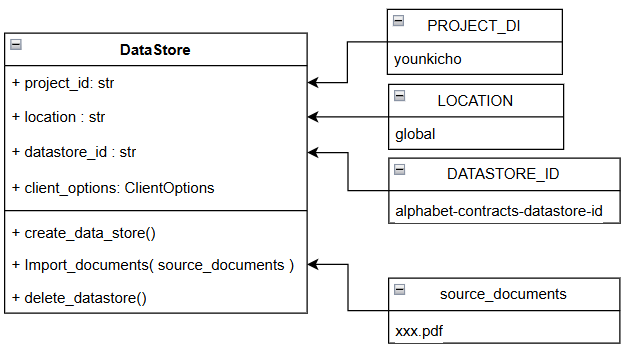

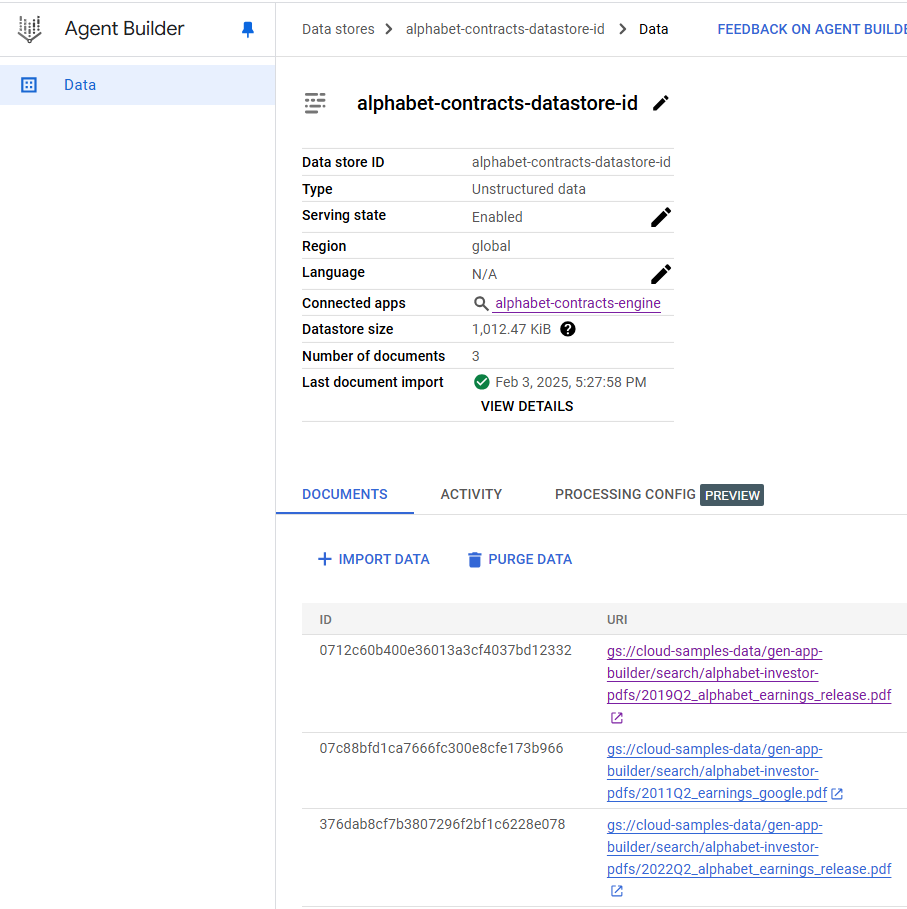

## 1.2 RAG Engine 생성

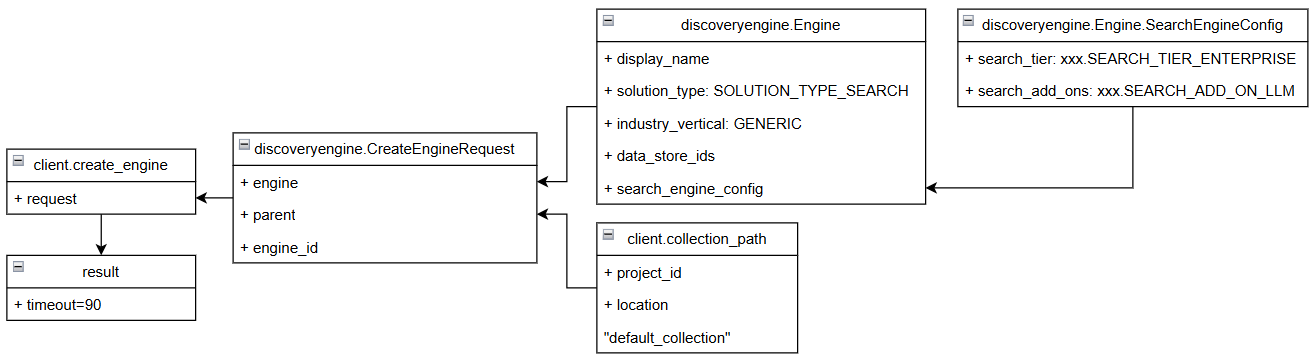

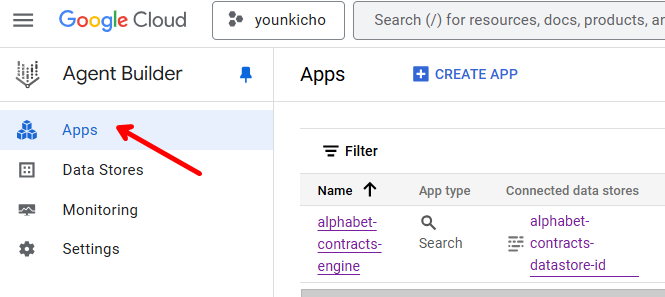

## 1.3 corpus 생성 및 RAG 검색

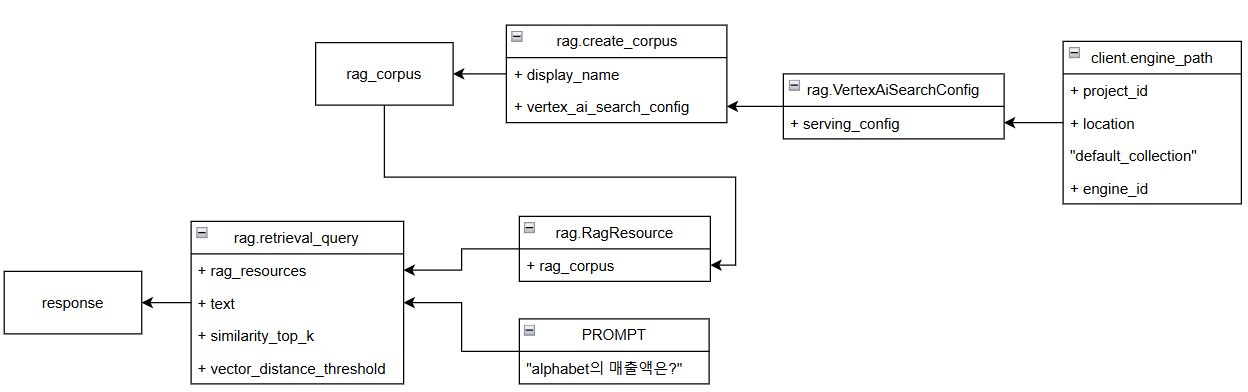

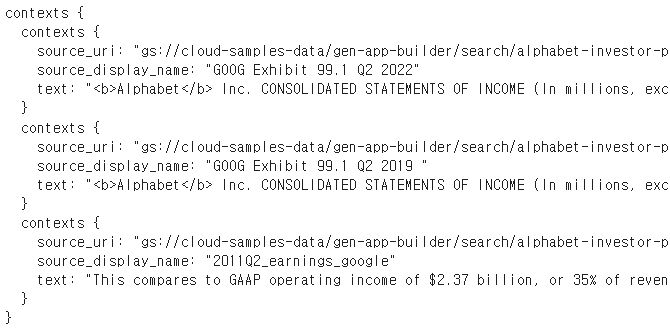

## 1.4 model 연동

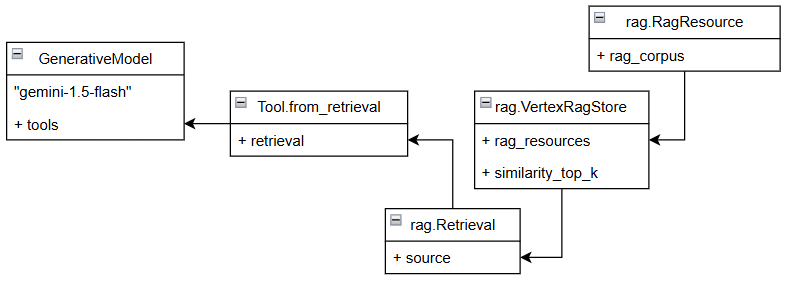

# 2. 코드 이해하기

## 2.1 초기화

### 2.1.1 라이브러리 설치

In [ ]:
!pip install google-cloud-discoveryengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.6 MB/s eta 0:00:00


In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.1.2 환경변수 설정 및 vertexai 초기화

In [ ]:
import os

PROJECT_ID=os.environ.get("GOOGLE_CLOUD_PROJECT")
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

In [ ]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## 2.2 datastore

### 2.2.1 class 생성

In [1]:
from google.cloud import discoveryengine
from google.api_core.client_options import ClientOptions

ImportError: cannot import name 'discoveryengine' from 'google.cloud' (unknown location)

In [ ]:
class DataStroe:
  def __init__(self, project_id, location, datastore_id):
    self.project_id = project_id
    self.location = location
    self.datastore_id = datastore_id
    self.client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )

  def create_data_store(self):
    client = discoveryengine.DataStoreServiceClient(client_options=self.client_options)

    data_store = discoveryengine.DataStore(
        display_name=self.datastore_id,
        industry_vertical=discoveryengine.IndustryVertical.GENERIC,
        content_config=discoveryengine.DataStore.ContentConfig.CONTENT_REQUIRED,
    )
    parent = client.collection_path(
        self.project_id,
        self.location,
        "default_collection"
    )
    request = discoveryengine.CreateDataStoreRequest(
            parent=parent,
            data_store=data_store,
            data_store_id=self.datastore_id,
        )
    operation = client.create_data_store(request=request)

    # Make the request
    response = operation.result(timeout=90)


  def import_documents(self, source_documents):
    # The full resource name of the search engine branch.
    # e.g. projects/{project}/locations/{location}/dataStores/{data_store_id}/branches/{branch}
    client = discoveryengine.DocumentServiceClient(client_options=self.client_options)

    parent = client.branch_path(
        project=self.project_id,
        location=self.location,
        data_store=self.datastore_id,
        branch="default_branch",
    )

    source_documents = source_documents;
    gcs_source = discoveryengine.GcsSource(
        input_uris=source_documents,
        data_schema="content"
    )
    request = discoveryengine.ImportDocumentsRequest(
        parent=parent,
        gcs_source=gcs_source,
        reconciliation_mode=discoveryengine.ImportDocumentsRequest.ReconciliationMode.INCREMENTAL,
    )

    # Make the request
    operation = client.import_documents(request=request)

    response = operation.result()


  def delete_datastore(self):
    client = discoveryengine.DataStoreServiceClient(client_options=self.client_options)

    name = client.data_store_path(
        self.project_id,
        self.location,
        self.datastore_id
    )
    request = discoveryengine.DeleteDataStoreRequest(name=name)

    client.delete_data_store(request=request)

### 2.2.2 datastore 생성 및 file import

In [ ]:
LOCATION = "global"
DATASTORE_ID="alphabet-contracts-datastore-id"

In [ ]:
_datastore = DataStroe(PROJECT_ID, LOCATION, DATASTORE_ID)
_datastore.create_data_store()

AlreadyExists: 409 DataStore projects/429718924597/locations/global/collections/default_collection/dataStores/alphabet-contracts-datastore-id already exists.

In [ ]:
gcs_uri = "gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs"
source_documents = [
        f"{gcs_uri}/2019Q2_alphabet_earnings_release.pdf",
        f"{gcs_uri}/2011Q2_earnings_google.pdf",
        f"{gcs_uri}/2022Q2_alphabet_earnings_release.pdf"
]
_datastore.import_documents(source_documents)

## 2.3 RAG Engine

In [ ]:
from vertexai.preview import rag

### 2.3.1 class 생성

In [ ]:
class RAGEngine:
  def __init__(self, project_id, location):
    self.project_id = project_id
    self.location = location

    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
    self.client = discoveryengine.EngineServiceClient(client_options=client_options)


  def create_engine(self, engine_name, engine_id, data_store_id):
    # Initialize request argument(s)
    search_engine_config=discoveryengine.Engine.SearchEngineConfig(
        # Options: SEARCH_TIER_STANDARD, SEARCH_TIER_ENTERPRISE
        search_tier=discoveryengine.SearchTier.SEARCH_TIER_ENTERPRISE,
        # Options: SEARCH_ADD_ON_LLM, SEARCH_ADD_ON_UNSPECIFIED
        search_add_ons=[discoveryengine.SearchAddOn.SEARCH_ADD_ON_LLM],
    )

    engine = discoveryengine.Engine(
        display_name=engine_name,
        solution_type=discoveryengine.SolutionType.SOLUTION_TYPE_SEARCH,
        industry_vertical=discoveryengine.IndustryVertical.GENERIC,
        data_store_ids=[data_store_id],
        search_engine_config=search_engine_config,
    )

    parent= self.client.collection_path(
        self.project_id,
        self.location,
        "default_collection"
    )
    request = discoveryengine.CreateEngineRequest(
        parent=parent,
        engine=engine,
        engine_id=engine_id,
    )

    # Make the request
    operation = self.client.create_engine(request=request)
    response = operation.result(timeout=90)


  def create_corpus(self, engine_id, rag_name):
    parent = self.client.engine_path(
        self.project_id,
        self.location,
        "default_collection"
        , engine_id)
    vertex_ai_search_config = rag.VertexAiSearchConfig(
      serving_config=f"{parent}/servingConfigs/default_search",
    )

    return rag.create_corpus(
        display_name=rag_name,
        vertex_ai_search_config=vertex_ai_search_config,
    )

  def delete_engine(self, engine_id):
    parent = self.client.engine_path(
        self.project_id,
        self.location,
        "default_collection"
        , engine_id)
    self.client.delete_engine(name=parent)

### 2.3.2 Engine 생성

In [ ]:
ENGINE_NAME= "alphabet-contracts-engine"
ENGINE_ID = f"{ENGINE_NAME}_id"

_ragEngine = RAGEngine(PROJECT_ID, LOCATION)

In [ ]:
_ragEngine.create_engine(ENGINE_NAME,ENGINE_ID, DATASTORE_ID)

### 2.3.3 UI를 통한 결과 확인

https://console.cloud.google.com/gen-app-builder/data-stores

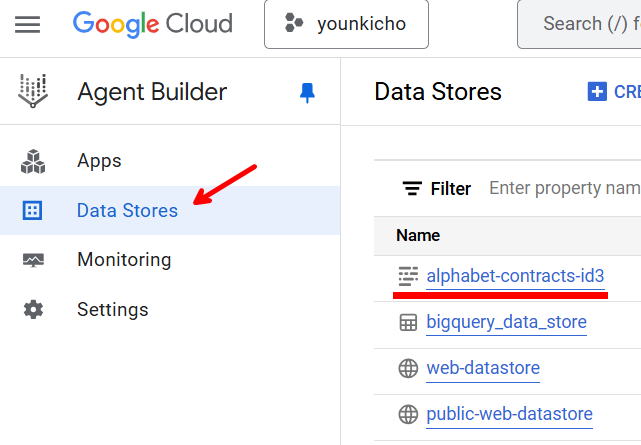

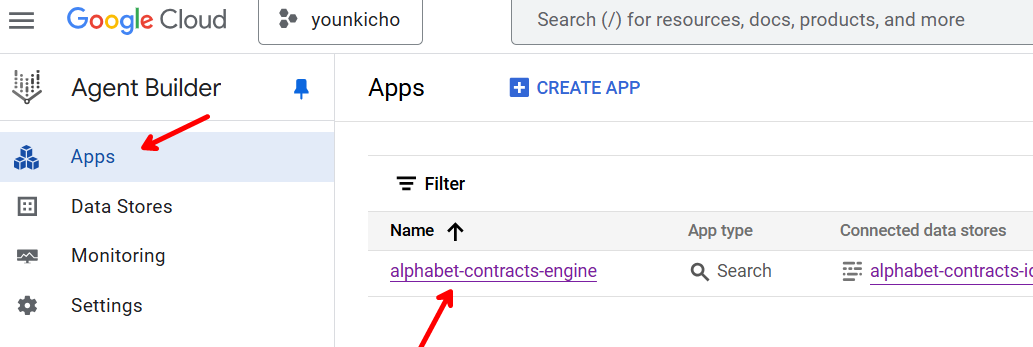

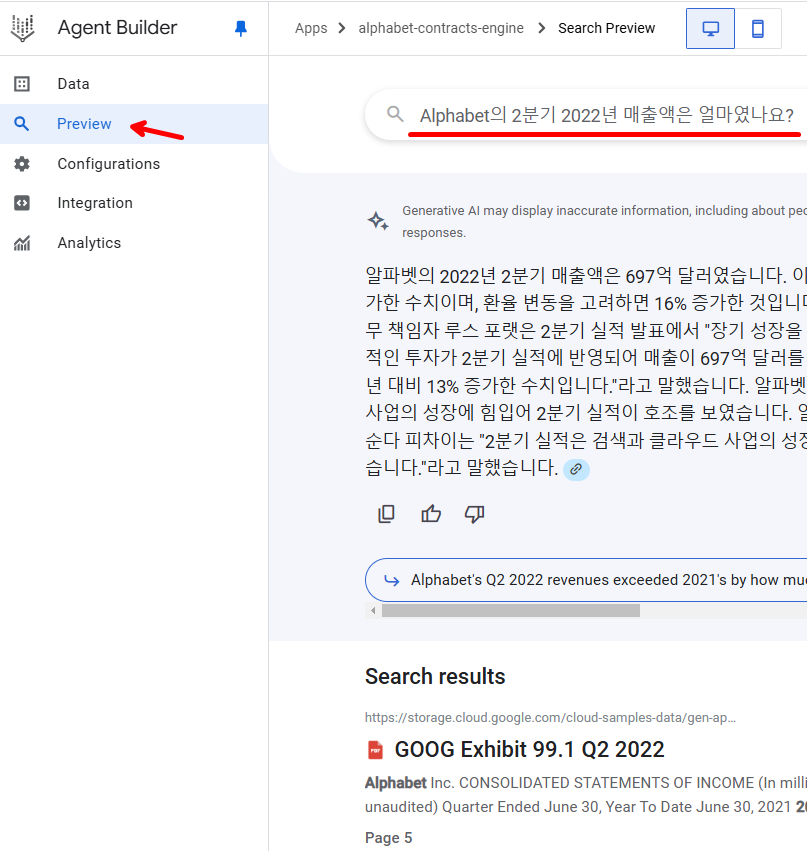

### 2.3.4 RAG corpus 생성

In [ ]:
from vertexai.preview.generative_models import GenerativeModel, Tool

CORPUS_NAME="alphabet-contracts-corpus"

rag_corpus = _ragEngine.create_corpus(ENGINE_ID, CORPUS_NAME)

### 2.3.5 RAG 검색

In [ ]:
GENERATE_CONTENT_PROMPT = (
    # "CFO는 누구얌?"
    "Alphabet의 2분기 2022년 매출액은 얼마였나요?"
    # "hello world"
)

In [ ]:
rag_resource = rag.RagResource(rag_corpus=rag_corpus.name)

response = rag.retrieval_query(
    rag_resources=[rag_resource],
    text=GENERATE_CONTENT_PROMPT,
    similarity_top_k=10,  # Optional
    vector_distance_threshold=0.5,  # Optional
    # vector_search_alpha=0.5, # Optional - Only supported for Weaviate
)

print(response)

contexts {
  contexts {
    source_uri: "gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/2022Q2_alphabet_earnings_release.pdf"
    source_display_name: "GOOG Exhibit 99.1 Q2 2022"
    text: "<b>Alphabet</b> Inc. CONSOLIDATED STATEMENTS OF INCOME (In millions, except per share amounts, unaudited) Quarter Ended June 30, Year To Date June 30, 2021 <b>2022</b> 2021 <b>2022</b> Revenues $ 61880 $ 69685 $ 117194 $ 137696 Costs and expenses: Cost of revenues 26227 30104 50330 59703 Research and development 7675 9841 15160 18960 Sales and marketing 5276 6630 9792 12455 General and administrative 3341 3657 6114 7031 Total costs and expenses 42519 50232 81396 98149 Income from operations 19361 19453 35798 39547 Other income (expense), net 2624 (439) 7470 (1599) Income before income taxes 21985 19014 43268 37948 Provision for income taxes 3460 3012 6813 5510 Net income $ 18525 $ 16002 $ 36455 $ 32438 Basic earnings per share of Class A, Class B, and Class C stock $ 1.38 $ 1.

In [ ]:
retrieved_context = " ".join(
    [context.text for context in response.contexts.contexts]
).replace("\n", "")

retrieved_context

'<b>Alphabet</b> Inc. CONSOLIDATED STATEMENTS OF INCOME (In millions, except per share amounts, unaudited) Quarter Ended June 30, Year To Date June 30, 2021 <b>2022</b> 2021 <b>2022</b> Revenues $ 61880 $ 69685 $ 117194 $ 137696 Costs and expenses: Cost of revenues 26227 30104 50330 59703 Research and development 7675 9841 15160 18960 Sales and marketing 5276 6630 9792 12455 General and administrative 3341 3657 6114 7031 Total costs and expenses 42519 50232 81396 98149 Income from operations 19361 19453 35798 39547 Other income (expense), net 2624 (439) 7470 (1599) Income before income taxes 21985 19014 43268 37948 Provision for income taxes 3460 3012 6813 5510 Net income $ 18525 $ 16002 $ 36455 $ 32438 Basic earnings per share of Class A, Class B, and Class C stock $ 1.38 $ 1.22 $ 2.72 $ 2.46 Diluted earnings per share of Class A, Class B, and Class C stock $ 1.36 $ 1.21 $ 2.68 $ 2.44 Number of shares used in basic earnings per share calculation 13379 13133 13422 13168 Number of share

### 2.3.6 model 적용

In [ ]:
rag_resource = rag.RagResource(rag_corpus=rag_corpus.name)
source=rag.VertexRagStore(
    rag_resources=[rag_resource],  # Currently only 1 corpus is allowed.
    similarity_top_k=10,
)
retrieval=rag.Retrieval(source=source)
rag_retrieval_tool = Tool.from_retrieval(retrieval = retrieval)

rag_model = GenerativeModel("gemini-1.5-flash", tools=[rag_retrieval_tool])

In [ ]:
response = rag_model.generate_content(GENERATE_CONTENT_PROMPT)

response.text

'Alphabet의 2022년 2분기 매출액은 696억 8500만 달러였습니다. \n'

## 2.4 정리

In [ ]:
delete_rag_corpus = True  # @param {type:"boolean"}

if delete_rag_corpus:
    rag.delete_corpus(name=rag_corpus.name)

Successfully deleted the RagCorpus.


In [ ]:
_ragEngine.delete_engine(ENGINE_ID)

In [ ]:
_datastore.delete_datastore()

# 3. reference

* https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/rag-engine/rag_engine_vertex_ai_search.ipynb
* https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1alpha.services.engine_service.EngineServiceClient#google_cloud_discoveryengine_v1alpha_services_engine_service_EngineServiceClient_engine_path

* https://github.com/GoogleCloudPlatform/generative-ai/blob/main/search/create_datastore_and_search.ipynb
* https://cloud.google.com/generative-ai-app-builder/docs/samples/genappbuilder-delete-data-store